# Model Age Cross-Prediction

In [1]:
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(
    context="paper", 
    style="whitegrid", 
    font_scale=1.2,
    rc={'figure.figsize': (10, 10), 'figure.dpi': 300}
)

## Get Data

In [2]:
from common.data import get_data

X, Y, demographics, population = get_data(wisc_level=5)
ages = demographics['Age']

print(f'X: {X.shape} | Y: {len(Y.keys())} | Age: {ages.shape} | Population: {population}')

X: (390, 34716) | Y: 6 | Age: (390,) | Population: adhd


In [3]:
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import RepeatedKFold, cross_validate, permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Run for one target, one age bin

In [4]:
selected_target = "WISC_FSIQ"
y = Y[selected_target]

print(f'{selected_target}: {y.shape}')

WISC_FSIQ: (390,)


In [5]:
from common.binning import bin_by_age

bins = bin_by_age(X, y, ages, y)
bin_1, bin_2, bin_3 = bins[0], bins[1], bins[2]
print(f'Bin 1: {bin_1[0].shape} | Bin 2: {bin_2[0].shape} | Bin 3: {bin_3[0].shape}')

Bin 1: (117, 34716) | Bin 2: (156, 34716) | Bin 3: (117, 34716)


### Set up the model pipeline, metrics, and cross-validation approach

In [9]:
def regression_scorer(reg, X, y):
#     y_pred = reg.predict(X)
    y_pred = reg.predict(X)[:, 0]
    return stats.pearsonr(y, y_pred)[0]

rkf = RepeatedKFold(n_splits=5, n_repeats=10)

In [27]:
%%time

estimators = [StandardScaler(), RidgeCV(alphas=[a for a in range(5000, 55000, 5000)], 
                                        scoring=regression_scorer, cv=rkf)]
pipe = make_pipeline(*estimators)
pipe.fit(X, y)
ridge_cv = pipe['ridgecv']
best_alpha = ridge_cv.alpha_

print(f'Target: {selected_target} | Alpha: {best_alpha} | Score: {ridge_cv.best_score_:.2f}')

Target: WISC_FSIQ | Alpha: 25000 | Score: 0.35
CPU times: user 1min 37s, sys: 2.03 s, total: 1min 39s
Wall time: 10 s


### Run cross-validation

In [29]:
%%time
bin_1_test, bin_2_test, bin_3_test = [], [], []

for bin_1_idx, bin_2_idx, bin_3_idx in zip(rkf.split(bin_1[0]), rkf.split(bin_2[0]), rkf.split(bin_3[0])):
    X_bin_1_train, X_bin_1_test = bin_1[0][bin_1_idx[0]], bin_1[0][bin_1_idx[1]]
    y_bin_1_train, y_bin_1_test = bin_1[1][bin_1_idx[0]], bin_1[1][bin_1_idx[1]]
    X_bin_2_train, X_bin_2_test = bin_2[0][bin_2_idx[0]], bin_2[0][bin_2_idx[1]]
    y_bin_2_train, y_bin_2_test = bin_2[1][bin_2_idx[0]], bin_2[1][bin_2_idx[1]]
    X_bin_3_train, X_bin_3_test = bin_3[0][bin_3_idx[0]], bin_3[0][bin_3_idx[1]]
    y_bin_3_train, y_bin_3_test = bin_3[1][bin_3_idx[0]], bin_3[1][bin_3_idx[1]]
    X_train = np.concatenate((X_bin_1_train, X_bin_2_train, X_bin_3_train))
    y_train = np.concatenate((y_bin_1_train, y_bin_2_train, y_bin_3_train))
#     print(X_train.shape, X_bin_1_test.shape, X_bin_2_test.shape, X_bin_3_test.shape)
    
#     pipe = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
    pipe = make_pipeline(StandardScaler(), PLSRegression(n_components=4))
    pipe.fit(X_train, y_train)

    bin_1_test.append(regression_scorer(pipe, X_bin_1_test, y_bin_1_test))
    bin_2_test.append(regression_scorer(pipe, X_bin_2_test, y_bin_2_test))
    bin_3_test.append(regression_scorer(pipe, X_bin_3_test, y_bin_3_test))

for metric in [bin_1_test, bin_2_test, bin_3_test]:
    print(f'{np.mean(metric):.2f}')

0.31
0.38
0.27
CPU times: user 2min 49s, sys: 6.72 s, total: 2min 56s
Wall time: 21.5 s


/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/bpho/.conda/envs/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


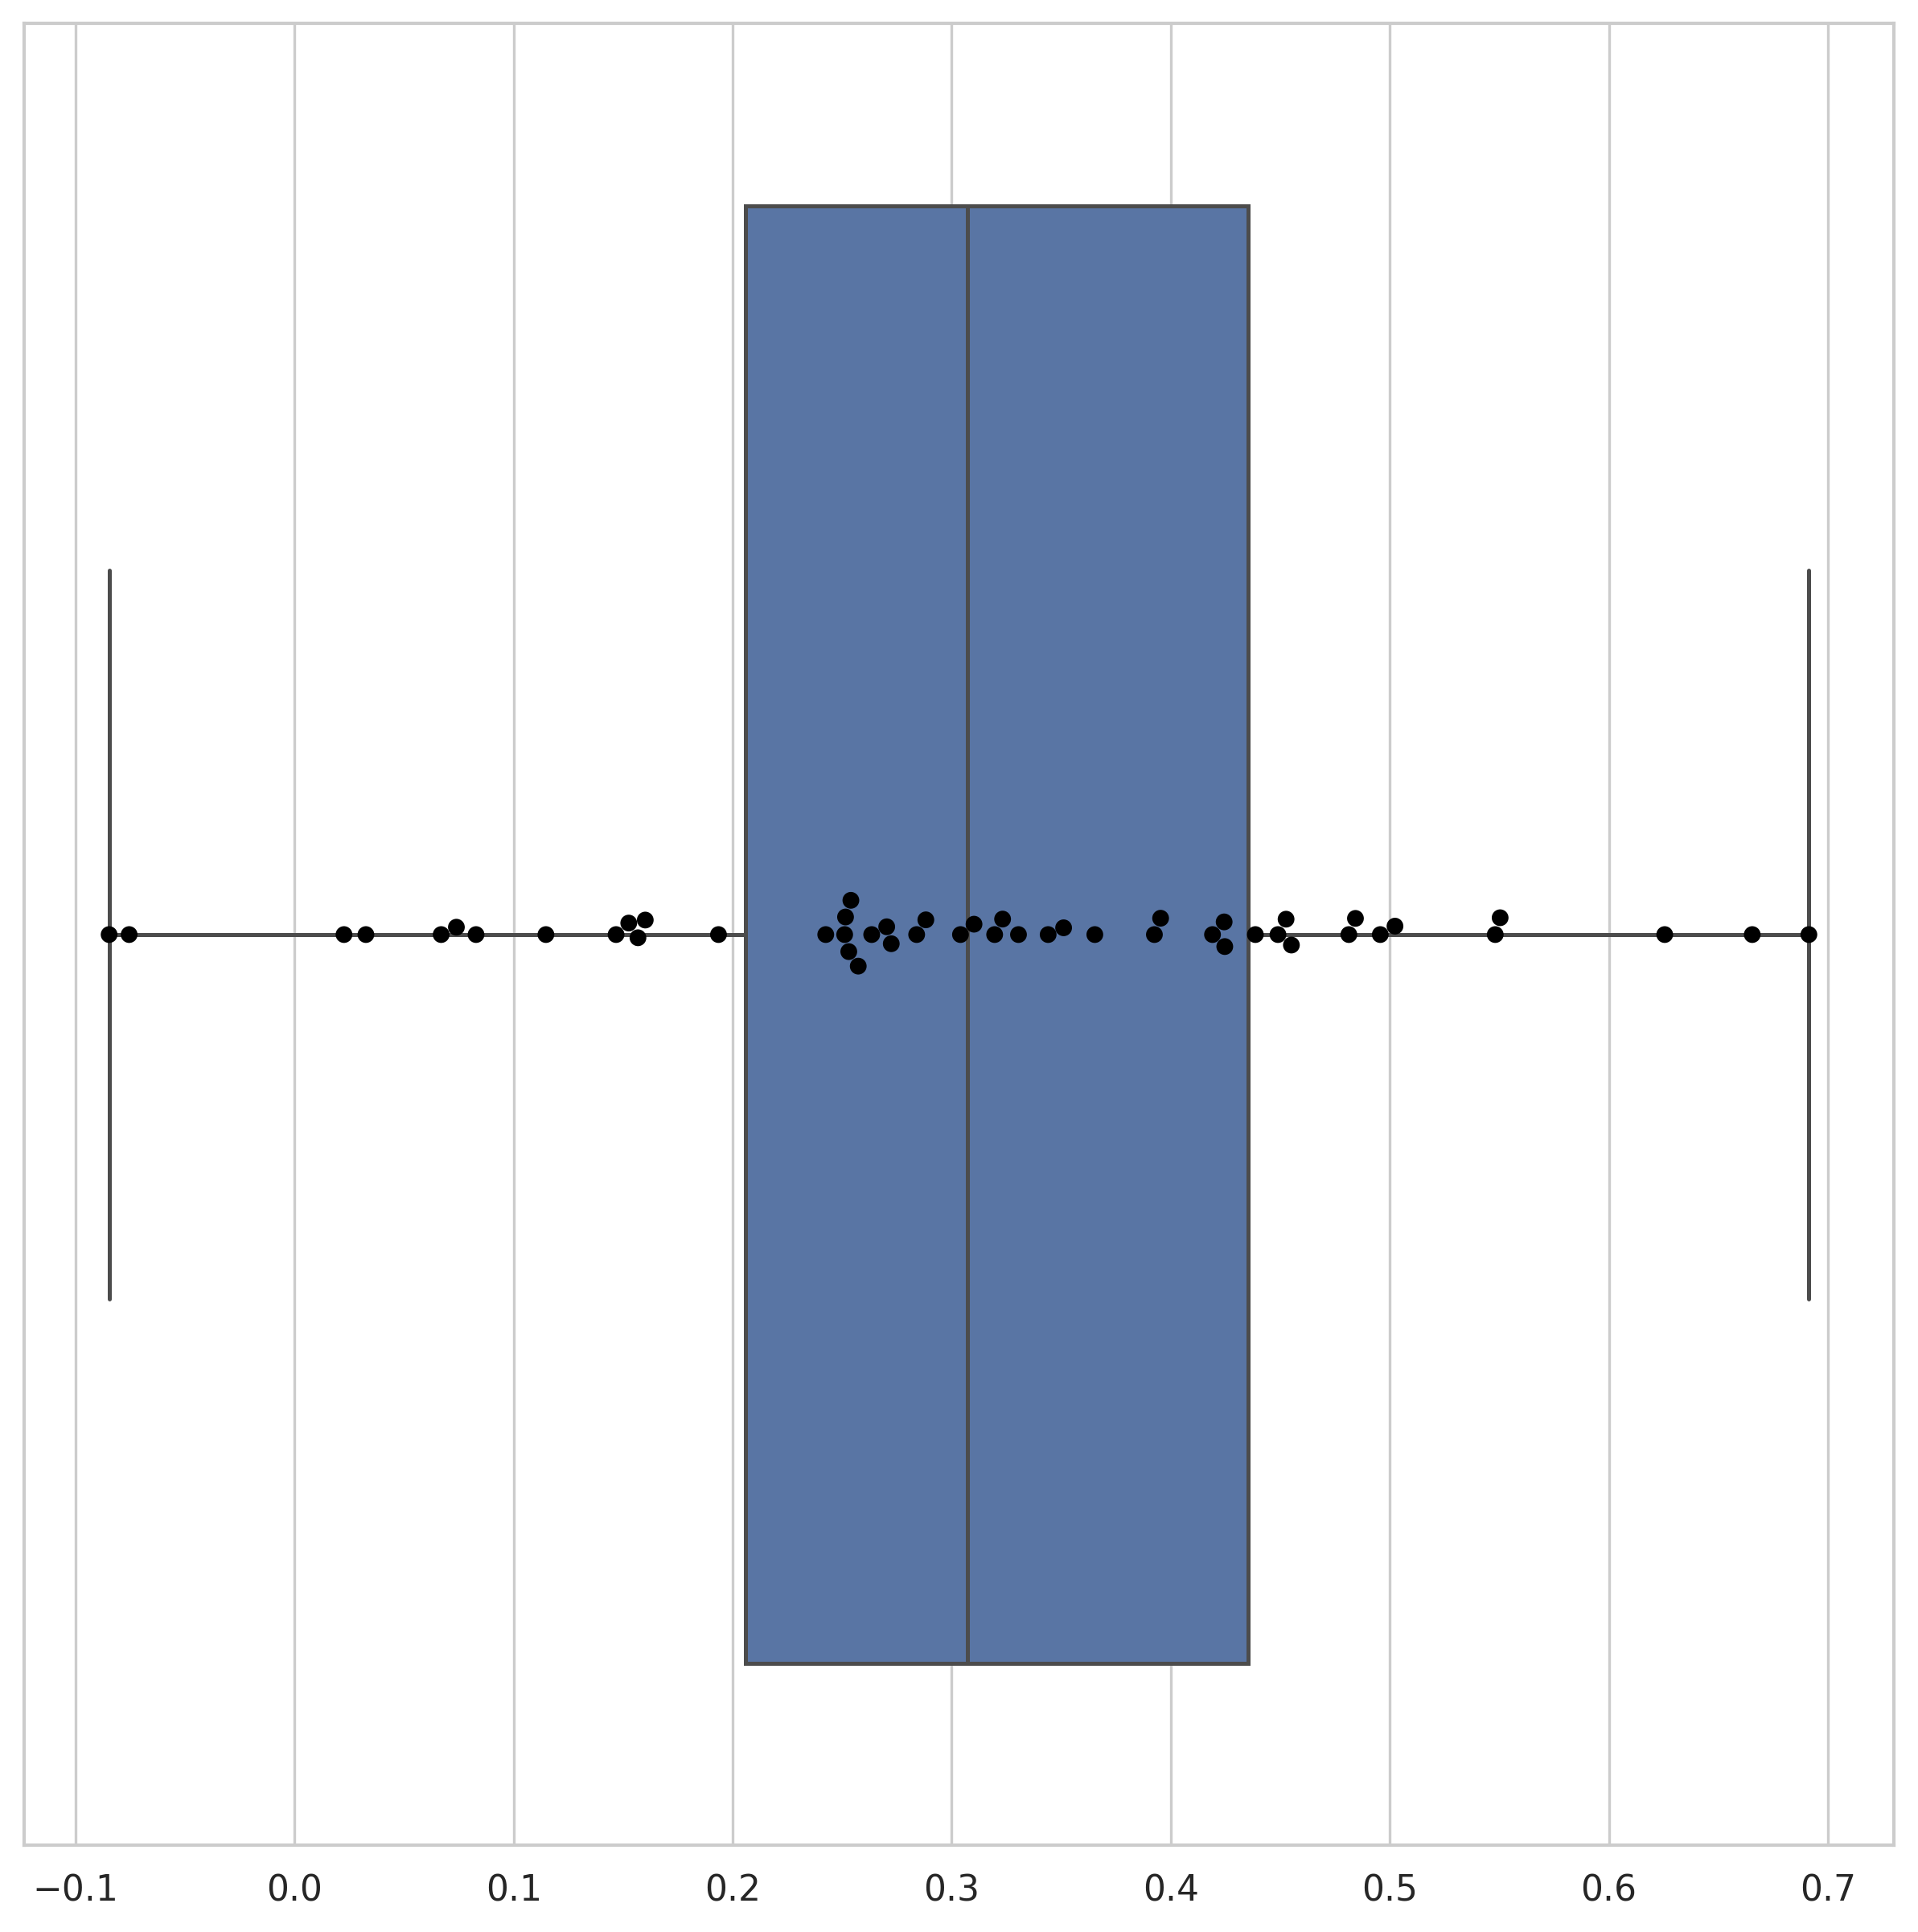

In [39]:
# ax = sns.boxplot({'Bin 1': bin_1_test, 'Bin 2': bin_2_test, 'Bin 3': bin_3_test})
ax = sns.boxplot(bin_1_test)
ax = sns.swarmplot(bin_1_test, color="0")

In [24]:
adhd_one_coefs = coefs.copy()

In [29]:
adhd_two_coefs = coefs.copy()

In [19]:
healthy_coefs = coefs.copy()

### Transfer model weights

#### ICC

In [34]:
%%time
import pingouin as pg

group_one = pd.DataFrame(adhd_one_coefs)
group_one['group'] = 'g1'

group_two = pd.DataFrame(healthy_coefs)
group_two['group'] = 'g2'

group_one_two = pd.concat([group_one, group_two])
icc_data = pd.melt(group_one_two, id_vars='group', var_name='connection', 
                   value_name='weight', ignore_index=False)
# display(icc_data)

icc = pg.intraclass_corr(data=icc_data, targets='connection', raters='group', ratings='weight').round(3)
icc.set_index("Type")

CPU times: user 32.2 s, sys: 228 ms, total: 32.4 s
Wall time: 32.4 s


,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.091,1.2,34715,34716,0.0,"[0.08, 0.1]"
ICC2,Single random raters,0.091,1.2,34715,34715,0.0,"[0.08, 0.1]"
ICC3,Single fixed raters,0.091,1.2,34715,34715,0.0,"[0.08, 0.1]"
ICC1k,Average raters absolute,0.167,1.2,34715,34716,0.0,"[0.15, 0.18]"
ICC2k,Average random raters,0.167,1.2,34715,34715,0.0,"[0.15, 0.18]"
ICC3k,Average fixed raters,0.167,1.2,34715,34715,0.0,"[0.15, 0.18]"
